In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import scipy as sc

In [2]:
img_size=(240, 320)
img_channels = 3
batch_size=32
epochs = 300

In [3]:
model_name = 'simple_covnet_model.tf'

In [4]:
train_size = 1000
validation_size = 500
test_size = 500

# Load the DataSet

Dataset citation:
- From Semi-Supervised to Transfer Counting of Crowds
C. C. Loy, S. Gong, and T. Xiang
in Proceedings of IEEE International Conference on Computer Vision, pp. 2256-2263, 2013 (ICCV)
- Cumulative Attribute Space for Age and Crowd Density Estimation
K. Chen, S. Gong, T. Xiang, and C. C. Loy
in Proceedings of IEEE Conference on Computer Vision and Pattern Recognition, pp. 2467-2474, 2013 (CVPR, Oral)
- Crowd Counting and Profiling: Methodology and Evaluation
C. C. Loy, K. Chen, S. Gong, T. Xiang
in S. Ali, K. Nishino, D. Manocha, and M. Shah (Eds.), Modeling, Simulation and Visual Analysis of Crowds, Springer, vol. 11, pp. 347-382, 2013
- Feature Mining for Localised Crowd Counting
K. Chen, C. C. Loy, S. Gong, and T. Xiang
British Machine Vision Conference, 2012 (BMVC)

In [5]:
dataset_path = '/Users/olove/Library/CloudStorage/OneDrive-Personal/AI datasets/CrowdCounter'

In [6]:
labels_df = pd.read_csv(dataset_path + '/labels.csv')
labels_df['image_name'] = labels_df['id'].map('seq_{:06d}.jpg'.format)
labels_df.drop("id", axis=1,inplace=True)
display(labels_df)

,count,image_name
0,35,seq_000001.jpg
1,41,seq_000002.jpg
2,41,seq_000003.jpg
3,44,seq_000004.jpg
4,41,seq_000005.jpg
...,...,...
1995,27,seq_001996.jpg
1996,27,seq_001997.jpg
1997,25,seq_001998.jpg
1998,26,seq_001999.jpg


In [7]:
labels_df = labels_df.sample(frac=1).reset_index(drop=True)
display(labels_df)

,count,image_name
0,25,seq_000515.jpg
1,21,seq_000865.jpg
2,35,seq_001822.jpg
3,27,seq_001744.jpg
4,30,seq_001901.jpg
...,...,...
1995,31,seq_001168.jpg
1996,19,seq_000601.jpg
1997,41,seq_000138.jpg
1998,35,seq_001399.jpg


In [8]:
if (train_size+validation_size+test_size) != len(labels_df):
    print('Dataset size is different from specified class sizes')
    exit(1)

training_df = labels_df[:train_size]
validation_df = labels_df[train_size:train_size+validation_size].reset_index(drop=True)
test_df = labels_df[train_size+validation_size:].reset_index(drop=True)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    
)

x_col_name = 'image_name'
y_col_name = 'count'

train_generator = datagen.flow_from_dataframe(
    training_df, 
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

validation_generator = datagen.flow_from_dataframe(
    validation_df,
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

Found 1000 validated image filenames.
Found 500 validated image filenames.
Found 500 validated image filenames.


# Define the model

In [10]:
inputs = keras.Input(shape= img_size + (img_channels,))

## Custom Simple Covnet

Downsizing using strides instead of MaxPolling in order to conserve location data

In [11]:
def basic_covnet_block(input):
    x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
    return x

## Custom Depthwise Seperable Convolution

In [12]:
def custom_depthwise_conv_block(input, sizes, repeat_per_size, stride = 1):
    x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(input)
    
    for size in sizes:
        for i in range(repeat_per_size - 1):
            x = layers.BatchNormalization()(x)
            x  = layers.Activation("relu")(x)
            x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x  = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, stride, padding='same', use_bias=False)(x)
        
    return x
        

# Output Layer

In [13]:
def basic_dense_block(covnet_param, sizes):
    x = layers.Flatten()(covnet_param)
    for size in sizes:
        x = layers.Dense(size, activation="relu")(x)
        x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)
    return outputs

In [14]:
covnet = custom_depthwise_conv_block(inputs, [32, 64, 128], 2, 2)
outputs = basic_dense_block(covnet, [128])
model = keras.Model(inputs=inputs, outputs=outputs)

2023-12-11 12:38:38.500733: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-11 12:38:38.500763: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-11 12:38:38.500770: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-11 12:38:38.501018: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-11 12:38:38.501048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 236, 316, 32)      2400      
                                                                 
 batch_normalization (Batch  (None, 236, 316, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 236, 316, 32)      0         
                                                                 
 separable_conv2d (Separabl  (None, 236, 316, 32)      1312      
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 236, 316, 32)      128   

# Train model

In [16]:
model.compile(loss="mse", optimizer="adam", metrics=["mae"])
# TODO: Try mae vs accuracy. mae should be better since we are adjusting it to get closer to the actual value

In [17]:
callbacks_list = [
#    keras.callbacks.EarlyStopping(
#        monitor="val_loss", patience=4
#    ),
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        monitor="val_loss",
        save_best_only=True
    ),
    keras.callbacks.TensorBoard()
]

In [18]:
Wsave = model.get_weights()

In [19]:
model.set_weights(Wsave)
history = model.fit(train_generator,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
)

Epoch 1/300


2023-12-11 12:38:39.630656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 2009.8494 - mae: 41.8181INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 15s 425ms/step - loss: 2009.8494 - mae: 41.8181 - val_loss: 1024.7258 - val_mae: 31.2356
Epoch 2/300
32/32 [==============================] - ETA: 0s - loss: 466.8030 - mae: 17.2241INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 13s 382ms/step - loss: 466.8030 - mae: 17.2241 - val_loss: 1014.3124 - val_mae: 31.0685
Epoch 3/300
32/32 [==============================] - ETA: 0s - loss: 305.5918 - mae: 13.7384INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 387ms/step - loss: 305.5918 - mae: 13.7384 - val_loss: 1007.2532 - val_mae: 30.9547
Epoch 4/300
32/32 [==============================] - ETA: 0s - loss: 280.7383 - mae: 13.2921INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 13s 400ms/step - loss: 280.7383 - mae: 13.2921 - val_loss: 1001.2316 - val_mae: 30.8573
Epoch 5/300
32/32 [==============================] - ETA: 0s - loss: 244.4113 - mae: 12.4341INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 378ms/step - loss: 244.4113 - mae: 12.4341 - val_loss: 991.1826 - val_mae: 30.6940
Epoch 6/300
32/32 [==============================] - ETA: 0s - loss: 232.1113 - mae: 12.1545INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 381ms/step - loss: 232.1113 - mae: 12.1545 - val_loss: 978.5800 - val_mae: 30.4880
Epoch 7/300
32/32 [==============================] - ETA: 0s - loss: 197.7407 - mae: 11.1908INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 373ms/step - loss: 197.7407 - mae: 11.1908 - val_loss: 962.9989 - val_mae: 30.2314
Epoch 8/300
32/32 [==============================] - ETA: 0s - loss: 183.0998 - mae: 10.8778INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 382ms/step - loss: 183.0998 - mae: 10.8778 - val_loss: 941.4893 - val_mae: 29.8733
Epoch 9/300
32/32 [==============================] - ETA: 0s - loss: 165.5517 - mae: 10.2148INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 378ms/step - loss: 165.5517 - mae: 10.2148 - val_loss: 914.6546 - val_mae: 29.4201
Epoch 10/300
32/32 [==============================] - ETA: 0s - loss: 141.6819 - mae: 9.4792INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 384ms/step - loss: 141.6819 - mae: 9.4792 - val_loss: 881.8102 - val_mae: 28.8550
Epoch 11/300
32/32 [==============================] - ETA: 0s - loss: 138.3082 - mae: 9.4625INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 373ms/step - loss: 138.3082 - mae: 9.4625 - val_loss: 844.0412 - val_mae: 28.1892
Epoch 12/300
32/32 [==============================] - ETA: 0s - loss: 126.5613 - mae: 9.0313INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 380ms/step - loss: 126.5613 - mae: 9.0313 - val_loss: 798.6996 - val_mae: 27.3650
Epoch 13/300
32/32 [==============================] - ETA: 0s - loss: 111.1480 - mae: 8.4059INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 374ms/step - loss: 111.1480 - mae: 8.4059 - val_loss: 744.1309 - val_mae: 26.3345
Epoch 14/300
32/32 [==============================] - ETA: 0s - loss: 110.4269 - mae: 8.3413INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 389ms/step - loss: 110.4269 - mae: 8.3413 - val_loss: 688.6917 - val_mae: 25.2392
Epoch 15/300
32/32 [==============================] - ETA: 0s - loss: 106.5495 - mae: 8.2554INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 374ms/step - loss: 106.5495 - mae: 8.2554 - val_loss: 610.5850 - val_mae: 23.6108
Epoch 16/300
32/32 [==============================] - ETA: 0s - loss: 101.4251 - mae: 8.0287INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 13s 412ms/step - loss: 101.4251 - mae: 8.0287 - val_loss: 524.4014 - val_mae: 21.6705
Epoch 17/300
32/32 [==============================] - ETA: 0s - loss: 90.0805 - mae: 7.5093INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 373ms/step - loss: 90.0805 - mae: 7.5093 - val_loss: 439.2886 - val_mae: 19.5629
Epoch 18/300
32/32 [==============================] - ETA: 0s - loss: 84.9586 - mae: 7.2958INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 380ms/step - loss: 84.9586 - mae: 7.2958 - val_loss: 352.0067 - val_mae: 17.1442
Epoch 19/300
32/32 [==============================] - ETA: 0s - loss: 90.3121 - mae: 7.5446INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 369ms/step - loss: 90.3121 - mae: 7.5446 - val_loss: 281.7196 - val_mae: 14.9504
Epoch 20/300
32/32 [==============================] - ETA: 0s - loss: 85.1072 - mae: 7.4080INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 372ms/step - loss: 85.1072 - mae: 7.4080 - val_loss: 218.0093 - val_mae: 12.7629
Epoch 21/300
32/32 [==============================] - ETA: 0s - loss: 83.0799 - mae: 7.2239INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 368ms/step - loss: 83.0799 - mae: 7.2239 - val_loss: 171.6203 - val_mae: 11.0313
Epoch 22/300
32/32 [==============================] - ETA: 0s - loss: 82.1583 - mae: 7.2550INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 375ms/step - loss: 82.1583 - mae: 7.2550 - val_loss: 144.6834 - val_mae: 9.9363
Epoch 23/300
32/32 [==============================] - ETA: 0s - loss: 79.5450 - mae: 7.0950INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 367ms/step - loss: 79.5450 - mae: 7.0950 - val_loss: 117.4450 - val_mae: 8.7312
Epoch 24/300
32/32 [==============================] - ETA: 0s - loss: 78.4709 - mae: 7.0921INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 373ms/step - loss: 78.4709 - mae: 7.0921 - val_loss: 109.9704 - val_mae: 8.4008
Epoch 25/300
32/32 [==============================] - ETA: 0s - loss: 78.7775 - mae: 7.0503INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 379ms/step - loss: 78.7775 - mae: 7.0503 - val_loss: 98.2549 - val_mae: 7.8829
Epoch 26/300
32/32 [==============================] - ETA: 0s - loss: 76.5597 - mae: 7.0037INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 379ms/step - loss: 76.5597 - mae: 7.0037 - val_loss: 88.5286 - val_mae: 7.4607
Epoch 27/300
32/32 [==============================] - 11s 328ms/step - loss: 76.1955 - mae: 6.9387 - val_loss: 89.2678 - val_mae: 7.4910
Epoch 28/300
32/32 [==============================] - ETA: 0s - loss: 76.4594 - mae: 6.9663INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 362ms/step - loss: 76.4594 - mae: 6.9663 - val_loss: 84.9896 - val_mae: 7.3151
Epoch 29/300
32/32 [==============================] - ETA: 0s - loss: 74.7918 - mae: 6.8670INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 372ms/step - loss: 74.7918 - mae: 6.8670 - val_loss: 83.7697 - val_mae: 7.2664
Epoch 30/300
32/32 [==============================] - 10s 324ms/step - loss: 71.8445 - mae: 6.7527 - val_loss: 83.8229 - val_mae: 7.2685
Epoch 31/300
32/32 [==============================] - ETA: 0s - loss: 73.1480 - mae: 6.7822INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 367ms/step - loss: 73.1480 - mae: 6.7822 - val_loss: 82.8540 - val_mae: 7.2292
Epoch 32/300
32/32 [==============================] - ETA: 0s - loss: 72.0277 - mae: 6.7259INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 384ms/step - loss: 72.0277 - mae: 6.7259 - val_loss: 77.5373 - val_mae: 7.0241
Epoch 33/300
32/32 [==============================] - 11s 325ms/step - loss: 73.6979 - mae: 6.8741 - val_loss: 80.9850 - val_mae: 7.1520
Epoch 34/300
32/32 [==============================] - 10s 324ms/step - loss: 73.3397 - mae: 6.7656 - val_loss: 78.4809 - val_mae: 7.0562
Epoch 35/300
32/32 [==============================] - ETA: 0s - loss: 72.0221 - mae: 6.7475INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 363ms/step - loss: 72.0221 - mae: 6.7475 - val_loss: 76.2935 - val_mae: 6.9768
Epoch 36/300
32/32 [==============================] - 11s 327ms/step - loss: 71.8526 - mae: 6.7475 - val_loss: 79.5348 - val_mae: 7.0932
Epoch 37/300
32/32 [==============================] - 10s 316ms/step - loss: 72.1143 - mae: 6.7029 - val_loss: 78.6220 - val_mae: 7.0593
Epoch 38/300
32/32 [==============================] - 10s 321ms/step - loss: 71.9328 - mae: 6.7503 - val_loss: 82.4439 - val_mae: 7.2106
Epoch 39/300
32/32 [==============================] - 10s 321ms/step - loss: 71.3829 - mae: 6.7185 - val_loss: 78.3131 - val_mae: 7.0471
Epoch 40/300
32/32 [==============================] - 11s 325ms/step - loss: 71.1429 - mae: 6.7330 - val_loss: 77.6386 - val_mae: 7.0221
Epoch 41/300
32/32 [==============================] - 10s 320ms/step - loss: 71.4950 - mae: 6.6967 - val_loss: 76.6814 - val_mae: 6.9876
Epoch 42/300
32/32 [==============================] - 

INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 377ms/step - loss: 71.1200 - mae: 6.6944 - val_loss: 75.9639 - val_mae: 6.9570
Epoch 47/300
32/32 [==============================] - 11s 326ms/step - loss: 71.3360 - mae: 6.7055 - val_loss: 77.0606 - val_mae: 6.9951
Epoch 48/300
32/32 [==============================] - 11s 327ms/step - loss: 70.0827 - mae: 6.6686 - val_loss: 79.2321 - val_mae: 7.0749
Epoch 49/300
32/32 [==============================] - 10s 320ms/step - loss: 70.8990 - mae: 6.7075 - val_loss: 78.3227 - val_mae: 7.0406
Epoch 50/300
32/32 [==============================] - 10s 319ms/step - loss: 70.2259 - mae: 6.6760 - val_loss: 81.4978 - val_mae: 7.1670
Epoch 51/300
32/32 [==============================] - 10s 320ms/step - loss: 70.6212 - mae: 6.6942 - val_loss: 81.8661 - val_mae: 7.1817
Epoch 52/300
32/32 [==============================] - 10s 315ms/step - loss: 69.8165 - mae: 6.6409 - val_loss: 79.6591 - val_mae: 7.0908
Epoch 53/300
32/32 [==============================] - 

INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 374ms/step - loss: 69.2224 - mae: 6.5878 - val_loss: 75.4674 - val_mae: 6.9232
Epoch 67/300
32/32 [==============================] - ETA: 0s - loss: 68.7786 - mae: 6.6278INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 370ms/step - loss: 68.7786 - mae: 6.6278 - val_loss: 75.1492 - val_mae: 6.9108
Epoch 68/300
32/32 [==============================] - 11s 328ms/step - loss: 69.3914 - mae: 6.6274 - val_loss: 83.6955 - val_mae: 7.2503
Epoch 69/300
32/32 [==============================] - 10s 309ms/step - loss: 69.0253 - mae: 6.5949 - val_loss: 76.8333 - val_mae: 6.9730
Epoch 70/300
32/32 [==============================] - ETA: 0s - loss: 68.1687 - mae: 6.5510INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 363ms/step - loss: 68.1687 - mae: 6.5510 - val_loss: 73.5104 - val_mae: 6.8490
Epoch 71/300
32/32 [==============================] - 11s 334ms/step - loss: 68.9925 - mae: 6.6189 - val_loss: 74.2634 - val_mae: 6.8757
Epoch 72/300
32/32 [==============================] - 10s 323ms/step - loss: 68.1171 - mae: 6.5788 - val_loss: 78.6883 - val_mae: 7.0420
Epoch 73/300
32/32 [==============================] - 10s 322ms/step - loss: 68.4937 - mae: 6.5804 - val_loss: 74.5661 - val_mae: 6.8845
Epoch 74/300
32/32 [==============================] - 10s 319ms/step - loss: 68.6060 - mae: 6.6113 - val_loss: 75.5595 - val_mae: 6.9211
Epoch 75/300
32/32 [==============================] - 10s 316ms/step - loss: 69.5190 - mae: 6.6297 - val_loss: 74.4536 - val_mae: 6.8802
Epoch 76/300
32/32 [==============================] - 10s 322ms/step - loss: 68.3027 - mae: 6.5500 - val_loss: 79.4606 - val_mae: 7.0715
Epoch 77/300
32/32 [==============================] - 

INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 12s 378ms/step - loss: 67.2122 - mae: 6.4692 - val_loss: 67.4944 - val_mae: 6.6322
Epoch 92/300
32/32 [==============================] - 11s 326ms/step - loss: 69.7895 - mae: 6.6552 - val_loss: 71.3847 - val_mae: 6.7525
Epoch 93/300
32/32 [==============================] - 10s 315ms/step - loss: 67.7489 - mae: 6.5549 - val_loss: 79.1352 - val_mae: 7.0500
Epoch 94/300
32/32 [==============================] - 10s 321ms/step - loss: 66.2719 - mae: 6.4873 - val_loss: 75.9043 - val_mae: 6.9195
Epoch 95/300
32/32 [==============================] - 10s 317ms/step - loss: 67.6311 - mae: 6.5248 - val_loss: 77.6137 - val_mae: 6.9858
Epoch 96/300
32/32 [==============================] - 10s 323ms/step - loss: 66.7170 - mae: 6.4563 - val_loss: 71.1294 - val_mae: 6.7390
Epoch 97/300
32/32 [==============================] - 10s 316ms/step - loss: 67.4192 - mae: 6.5355 - val_loss: 77.5813 - val_mae: 6.9837
Epoch 98/300
32/32 [==============================] - 

INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 11s 357ms/step - loss: 62.1226 - mae: 6.2449 - val_loss: 67.4333 - val_mae: 6.5422
Epoch 165/300
32/32 [==============================] - 11s 328ms/step - loss: 62.6962 - mae: 6.2810 - val_loss: 72.1474 - val_mae: 6.7474
Epoch 166/300
32/32 [==============================] - 10s 323ms/step - loss: 62.1925 - mae: 6.2441 - val_loss: 78.2302 - val_mae: 7.0165
Epoch 167/300
32/32 [==============================] - 10s 319ms/step - loss: 62.3251 - mae: 6.2712 - val_loss: 73.5333 - val_mae: 6.8074
Epoch 168/300
32/32 [==============================] - 10s 312ms/step - loss: 62.1436 - mae: 6.2543 - val_loss: 75.2299 - val_mae: 6.8821
Epoch 169/300
32/32 [==============================] - 10s 325ms/step - loss: 61.7352 - mae: 6.2371 - val_loss: 71.7093 - val_mae: 6.7287
Epoch 170/300
32/32 [==============================] - 10s 314ms/step - loss: 62.6499 - mae: 6.2929 - val_loss: 69.9073 - val_mae: 6.6497
Epoch 171/300
32/32 [===========================

INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 13s 395ms/step - loss: 61.6337 - mae: 6.2142 - val_loss: 66.8456 - val_mae: 6.5133
Epoch 177/300
32/32 [==============================] - 11s 337ms/step - loss: 62.2486 - mae: 6.2547 - val_loss: 69.2437 - val_mae: 6.6206
Epoch 178/300
32/32 [==============================] - 10s 321ms/step - loss: 62.3886 - mae: 6.2851 - val_loss: 79.5211 - val_mae: 7.0769
Epoch 179/300
32/32 [==============================] - 10s 322ms/step - loss: 61.8982 - mae: 6.2225 - val_loss: 79.0051 - val_mae: 7.0531
Epoch 180/300
32/32 [==============================] - 10s 324ms/step - loss: 61.2669 - mae: 6.2124 - val_loss: 72.0040 - val_mae: 6.7404
Epoch 181/300
32/32 [==============================] - 10s 316ms/step - loss: 61.4972 - mae: 6.2130 - val_loss: 80.1162 - val_mae: 7.1052
Epoch 182/300
32/32 [==============================] - 11s 335ms/step - loss: 61.5044 - mae: 6.2250 - val_loss: 79.8732 - val_mae: 7.0943
Epoch 183/300
32/32 [===========================

INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 104s 3s/step - loss: 61.8482 - mae: 6.2356 - val_loss: 65.0512 - val_mae: 6.4290
Epoch 190/300
32/32 [==============================] - 63s 2s/step - loss: 65.0385 - mae: 6.3326 - val_loss: 72.9043 - val_mae: 6.7809
Epoch 191/300
32/32 [==============================] - 10s 323ms/step - loss: 60.6101 - mae: 6.1892 - val_loss: 69.7111 - val_mae: 6.6408
Epoch 192/300
32/32 [==============================] - 394s 13s/step - loss: 61.5149 - mae: 6.2493 - val_loss: 70.7678 - val_mae: 6.6867
Epoch 193/300
32/32 [==============================] - 12s 374ms/step - loss: 60.7329 - mae: 6.1782 - val_loss: 74.5011 - val_mae: 6.8534
Epoch 194/300
32/32 [==============================] - 11s 335ms/step - loss: 61.1857 - mae: 6.2139 - val_loss: 78.3882 - val_mae: 7.0296
Epoch 195/300
32/32 [==============================] - 10s 320ms/step - loss: 60.8496 - mae: 6.1906 - val_loss: 75.5018 - val_mae: 6.8981
Epoch 196/300
32/32 [==============================] -

INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 11s 358ms/step - loss: 59.1836 - mae: 6.1245 - val_loss: 64.5180 - val_mae: 6.3927
Epoch 278/300
32/32 [==============================] - 10s 305ms/step - loss: 57.9246 - mae: 6.0572 - val_loss: 67.3907 - val_mae: 6.5269
Epoch 279/300
32/32 [==============================] - 10s 305ms/step - loss: 58.2839 - mae: 6.0607 - val_loss: 66.4446 - val_mae: 6.4818
Epoch 280/300
32/32 [==============================] - 10s 307ms/step - loss: 56.9376 - mae: 6.0038 - val_loss: 73.6631 - val_mae: 6.8139
Epoch 281/300
32/32 [==============================] - 10s 300ms/step - loss: 57.8374 - mae: 6.0487 - val_loss: 70.9028 - val_mae: 6.6897
Epoch 282/300
32/32 [==============================] - 10s 297ms/step - loss: 56.9179 - mae: 5.9789 - val_loss: 72.4322 - val_mae: 6.7595
Epoch 283/300
32/32 [==============================] - 10s 300ms/step - loss: 57.5785 - mae: 6.0371 - val_loss: 81.0912 - val_mae: 7.1759
Epoch 284/300
32/32 [===========================

In [20]:
model.evaluate(validation_generator)

16/16 [==============================] - 1s 70ms/step - loss: 66.5030 - mae: 6.4840


[66.50296783447266, 6.484036922454834]

In [21]:
model.evaluate(test_generator)

16/16 [==============================] - 1s 78ms/step - loss: 66.7571 - mae: 6.5193


[66.75706481933594, 6.519329071044922]

# Represent history

In [22]:
print(history.history.keys())
epochs = (0, 100)

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


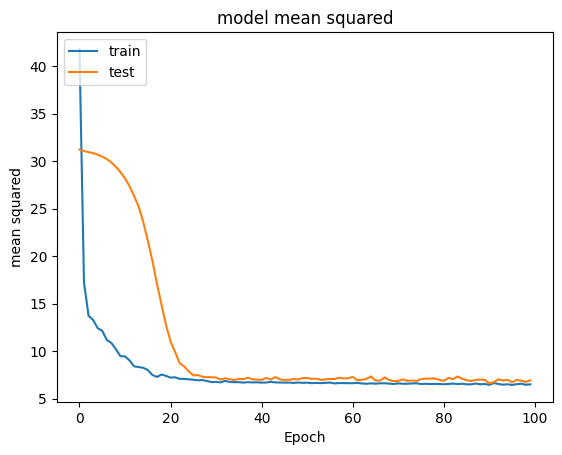

In [23]:
plt.plot(history.history['mae'][epochs[0]:epochs[1]])
plt.plot(history.history['val_mae'][epochs[0]:epochs[1]])
plt.title('model mean squared')
plt.ylabel('mean squared')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

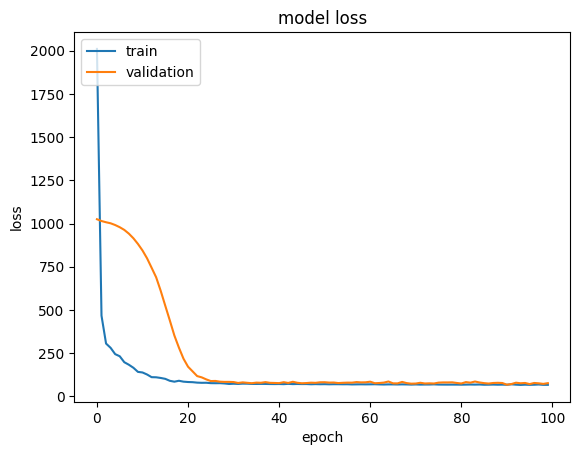

In [24]:
plt.plot(history.history['loss'][epochs[0]:epochs[1]])
plt.plot(history.history['val_loss'][epochs[0]:epochs[1]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Bibliografia

- Deep Learning with Python, Second Edition. François Chollet